In [1]:
pwd

'/home/pj/Documents/STEMtranslator/cydev'

In [12]:
import crystalgrowth as cg

In [22]:
import numpy as np

In [18]:
cg.sin2(np.pi/2)

1.0

In [40]:
def nucleate(blank_array,nucleation_sites):
    """Seeds the structure with given number of sites

    Sites are selected randomly in the domain.

    At each site, an orientation in [-pi/2, pi/2) is selected and assigned to the given location.

    There is no check for distance between sites or
    to ensure sites are unique.

    Passing a random seed allows reproducible results. If no seed is passed, the generator will not be seeded
    and should produce random results each time.

    This function is dimension independent so will work in both 2d and 3d

    Args:
        blank_array: array to fill with seeds
        nucleation_sites: number of nucleation sites to use
        random_seed: seed for random number generator

    Returns:
        A tuple with (the seeded array, a list of the seed locations, the orientation at each location)
    """
    positions = [[np.random.randint(0, dim) for dim in blank_array.shape] for i in range(nucleation_sites)]
    positions = np.array(positions)
    orientations = np.random.uniform(-np.pi/2, np.pi/2, size=nucleation_sites)
    for pos, orient in zip(positions, orientations):
        blank_array[tuple(pos)] = orient
    return blank_array, positions, orientations

In [143]:
%load_ext line_profiler

In [146]:
%lprun -f nucleate nucleate(np.empty((512,512)),300)

Timer unit: 1e-06 s

Total time: 0.002637 s
File: <ipython-input-40-fd2ea1fe6c1d>
Function: nucleate at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nucleate(blank_array,nucleation_sites):
     2                                               """Seeds the structure with given number of sites
     3                                           
     4                                               Sites are selected randomly in the domain.
     5                                           
     6                                               At each site, an orientation in [-pi/2, pi/2) is selected and assigned to the given location.
     7                                           
     8                                               There is no check for distance between sites or
     9                                               to ensure sites are unique.
    10                                           
    

In [19]:
%load_ext Cython

In [105]:
%%cython --annotate
 
import numpy as np
cimport numpy as np
cimport cython

from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport M_PI

DTYPE1 = np.int
DTYPE2 = np.double

ctypedef np.int_t DTYPE1_t
ctypedef np.double_t DTYPE2_t

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_nucleate(np.ndarray blank_array, nucleation_sites):
    
    """Seeds the structure with given number of sites

    Sites are selected randomly in the domain.

    At each site, an orientation in [-pi/2, pi/2) is selected and assigned to the given location.

    There is no check for distance between sites or
    to ensure sites are unique.

    Passing a random seed allows reproducible results. If no seed is passed, the generator will not be seeded
    and should produce random results each time.

    This function is dimension independent so will work in both 2d and 3d

    Args:
        blank_array: array to fill with seeds
        nucleation_sites: number of nucleation sites to use
        random_seed: seed for random number generator

    Returns:
        A tuple with (the seeded array, a list of the seed locations, the orientation at each location)
    """
    cdef int ypos
    cdef int xpos
    cdef float orient
    cdef int xmax = blank_array.shape[1]
    cdef int ymax = blank_array.shape[0]
    cdef np.ndarray[DTYPE1_t,ndim=2] positions = np.empty((nucleation_sites,2),dtype=DTYPE1)
    cdef np.ndarray[DTYPE2_t, ndim=1] orientations = np.empty(nucleation_sites,dtype=DTYPE2)
    for i in range(nucleation_sites):
        ypos =  int(rand()/RAND_MAX*ymax)
        xpos = int(rand()/RAND_MAX*xmax)
        positions[i,0] = ypos
        positions[i,1] = xpos
        orient = rand()/RAND_MAX*M_PI - M_PI/2
        orientations[i] = orient
        blank_array[ypos,xpos] = orient
        
    return blank_array, positions, orientations

In [98]:
%timeit nucleate(np.empty((512,512)),300)

1.45 ms ± 3.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [106]:
%timeit cy_nucleate(np.empty((512,512)),300)

73.7 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [120]:
def add_orient(grow_array, location, base_orientation, mutate):
    """Add orientation at given location and store location in list of crystal sites

    The orientation is the base orientation plus a random factor in the range [-mutate, mutate]

    This function is dimension independent so will work in both 2d and 3d

    Args:
        grow_array: The crystal array data
        location: location of site to add orientation
        base_orientation: base orientation value
        mutate: mutation factor
        next_crystal_idx: list of indices to check in next growth cycle
    """
    # if there is already an orientation here, don't do anything
    if np.isnan(grow_array[location]):

        new_orient = base_orientation + np.random.uniform(-mutate, mutate)

        # force to be within range [-pi/2, pi/2]
        if new_orient > (0.5 * np.pi):
            new_orient %= -(0.5 * np.pi)
        if new_orient < -(0.5 * np.pi):
            new_orient %= (0.5 * np.pi)

        grow_array[location] = new_orient
#         next_crystal_idx.append(location)

In [136]:
%%cython --annotate

import numpy as np
cimport numpy as np
cimport cython

from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport M_PI, isnan

DTYPE1 = np.int
DTYPE2 = np.float

ctypedef np.int_t DTYPE1_t
ctypedef np.float_t DTYPE2_t


def cyadd_orient(np.ndarray[DTYPE2_t,ndim=2] grow_array, list location, float base_orientation,float mutate):
    
    cdef int ypos = location[0]
    cdef int xpos = location[1]
    
    cdef float new_orient
    if isnan(grow_array[ypos, xpos]):
        
        new_orient = base_orientation + rand()/RAND_MAX*mutate*2 - mutate
        
        if new_orient > 0.5*M_PI:
            new_orient %= -0.5*M_PI
        elif new_orient < -0.5*M_PI:
            new_orient %= 0.5*M_PI
        
        grow_array[ypos, xpos] = new_orient

In [109]:
grow_array, positions, orientations = cy_nucleate(np.empty((512,512)),300)

In [118]:
[positions[0,0],positions[0,1]]

[272, 509]

In [121]:
%timeit add_orient(grow_array,(positions[0,0],positions[0,1]),orientations,0)

1.29 µs ± 2.57 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [137]:
%timeit cyadd_orient(grow_array,[positions[0,0],positions[0,1]],orientations[0],0)

486 ns ± 4.94 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [141]:
%%cython --annotate

from libc.stdlib cimport rand, RAND_MAX
from libc.math cimport M_PI

import numpy as np
cimport numpy as np
cimport cython

DTYPE = np.float

ctypedef np.float_t DTYPE_t
@cython.boundscheck(False)
@cython.wraparound(False)
def pi_uniform(int len_array):
    cdef np.ndarray[DTYPE_t,ndim=1] array = np.empty(len_array,dtype=DTYPE)
    for i in range(len_array):
        array[i] = rand()/RAND_MAX*M_PI - M_PI/2
    return array

In [142]:
%timeit pi_uniform(100000)

538 µs ± 168 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
import matplotlib.pyplot as plt

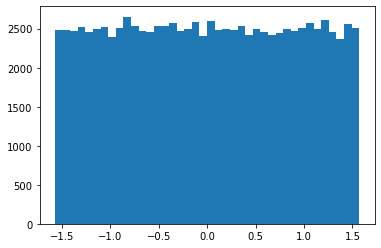

In [78]:
_ = plt.hist(test1,bins=40)

In [80]:
%timeit np.random.randint(100000)

1.69 µs ± 5.99 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
